# MLP


In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 10
batch_size = 16
epsilon_std = 1.0

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [ ]:
def build_encoder():
    img = Input(shape=img_shape)
    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(latent_dim)(h)
    log_var = Dense(latent_dim)(h)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_var])
    return Model(img, z)

In [ ]:
def build_decoder():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    # tanh is more robust: gradient not equal to 0 around 0
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    model.summary()
    z = Input(shape=(latent_dim,))
    img = model(z)
    return Model(z, img)

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()
    encoded_repr = Input(shape=(latent_dim,))
    validity = model(encoded_repr)
    return Model(encoded_repr, validity)

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape=img_shape)
# The generator takes the image, encodes it and reconstructs it
# from the encoding
encoded_repr = encoder(img)
reconstructed_img = decoder(encoded_repr)

# For the adversarial_autoencoder model we will only train the generator
# if discriminator is attached to generator, set this flag to fix discriminator
discriminator.trainable = False

# The discriminator determines validity of the encoding
validity = discriminator(encoded_repr)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(img, [reconstructed_img, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.001], optimizer=optimizer)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)              

In [ ]:
def train(epochs, batch_size=128, sample_interval=50):
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        #  Train Discriminator

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, latent_dim))

        # Train the discriminator
        # let latent_real's output is close to 1
        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        # let latent_fake's output is close to 0
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        # decrease reconstruction error and let discriminator's output is close to 1
        g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # If at save interval
        if epoch % sample_interval == 0:
            # Plot the progress
            print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
                epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
            # save generated image samples
            sample_images(epoch)

In [ ]:
# Save generated images per specified epochs
def sample_images(epoch):
    r, c = 5, 5
    z = np.random.normal(size=(r * c, latent_dim))
    gen_imgs = decoder.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
epochs = 2000
sample_interval = 200
sample_count = epochs/sample_interval

In [ ]:
train(epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)

0 [D loss: 0.712140, acc: 43.75%] [G loss: 0.958268, mse: 0.958529]
200 [D loss: 0.135875, acc: 100.00%] [G loss: 0.149161, mse: 0.145087]
400 [D loss: 0.027151, acc: 100.00%] [G loss: 0.141855, mse: 0.136363]
600 [D loss: 0.032648, acc: 100.00%] [G loss: 0.107190, mse: 0.101383]
800 [D loss: 0.043477, acc: 96.88%] [G loss: 0.122408, mse: 0.116417]
1000 [D loss: 0.058001, acc: 96.88%] [G loss: 0.118370, mse: 0.113549]
1200 [D loss: 0.111710, acc: 96.88%] [G loss: 0.095911, mse: 0.090274]
1400 [D loss: 0.311848, acc: 87.50%] [G loss: 0.107648, mse: 0.104659]
1600 [D loss: 0.327442, acc: 81.25%] [G loss: 0.085528, mse: 0.081999]
1800 [D loss: 0.266136, acc: 90.62%] [G loss: 0.092068, mse: 0.089136]


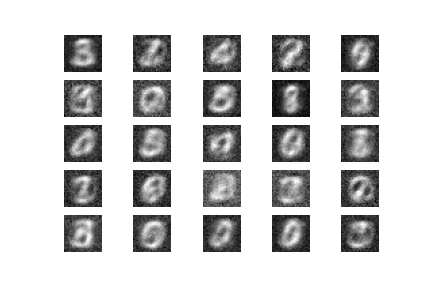

In [ ]:
Image.open('mnist_200.png')

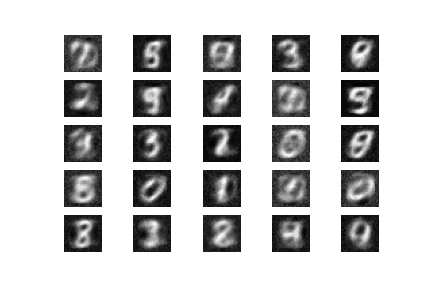

In [ ]:
Image.open('mnist_600.png')

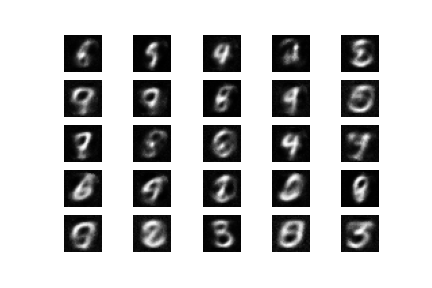

In [ ]:
Image.open('mnist_1000.png')

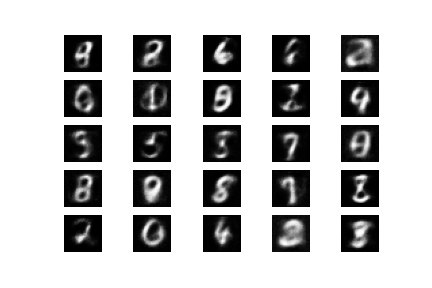

In [ ]:
Image.open('mnist_1400.png')

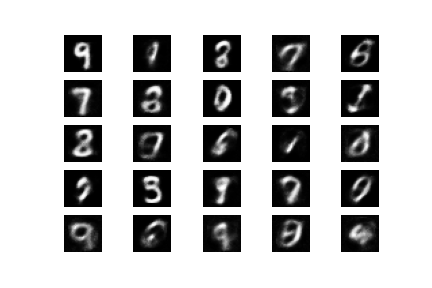

In [ ]:
Image.open('mnist_1800.png')

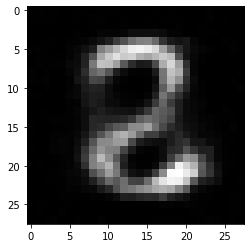

In [ ]:
z = np.random.normal(size=(1, latent_dim))
gen_imgs = decoder.predict(z)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

# CNN

In [ ]:
import tensorflow as tf
tf.__version__




'2.4.1'

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

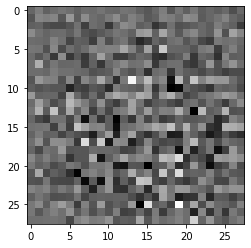

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00327316]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

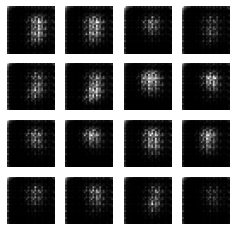

Time for epoch 1 is 710.7710611820221 sec


KeyboardInterrupt: ignored

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

FileNotFoundError: ignored